## Contribution of high firing neurons to behavior or stimulus encoding


In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     |████████████████████████████████| 88 kB 1.1 MB/s 
     |████████████████████████████████| 1.1 MB 13.9 MB/s 


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [18]:
neuron_data = dat['sresp']
running_data = dat['run']

In [151]:

# get avg firing rates of neurons, sort
avg_firing_neurons = np.mean(neuron_data, axis=1)
#plt.hist(avg_firing_neurons, bins='auto')
std_all_neurons = np.std(avg_firing_neurons)
mean_all_neurons = np.mean(avg_firing_neurons)
sorted_by_avg_firing = np.flip(np.argsort(avg_firing_neurons))

In [156]:
# Split the population
high_criterion = mean_all_neurons + 2 * std_all_neurons
low_criterion = mean_all_neurons - 2 * std_all_neurons

# Based on criterion
#high_firing_neurons = neuron_data[avg_firing_neurons > high_criterion]
#low_firing_neurons = neuron_data[avg_firing_neurons < low_criterion]
#all_other_neurons = neuron_data[avg_firing_neurons <= high_criterion]

folds = 5
fold = int(avg_firing_neurons.shape[0]/folds)
high_firing_neurons = neuron_data[sorted_by_avg_firing][:fold]
low_firing_neurons = neuron_data[sorted_by_avg_firing][-fold:]
# select n random neurons from all, where n is number of high firing neurons
#index = np.random.randint(0, all_other_neurons.shape[0], size=high_firing_neurons.shape[0])
#all_other_neurons = all_other_neurons[index]

(599, 7018)


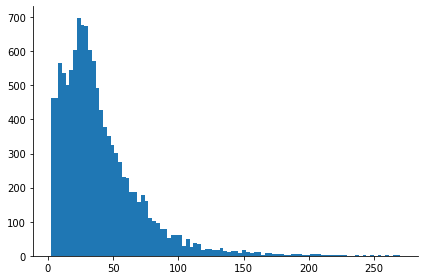

In [153]:
print(low_firing_neurons.shape)
mean_of_low_firing_neurons = np.mean(low_firing_neurons, axis=1)
plt.hist(avg_firing_neurons, bins='auto')
plt.show()

In [45]:
# getting correlation between neurons and running
def get_correlations(neurons, behavior):
  pearsons_neurons = np.empty((neurons.shape[0], 2)) # r, p-value
  for idx, neuron in enumerate(neurons):
    pearsons_neurons[idx][0], pearsons_neurons[idx][1] = stats.pearsonr(neuron, behavior)
  return pearsons_neurons

In [137]:
pearsons_high_firing_neurons = get_correlations(high_firing_neurons, running_data)
pearsons_low_firing_neurons = get_correlations(low_firing_neurons, running_data)
#pearsons_all_neurons = get_correlations(neuron_data, running_data)
#pearsons_all_other_neurons = get_correlations(all_other_neurons, running_data)

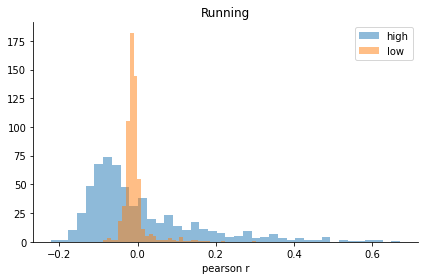

In [138]:

plt.figure()
bins = 40
plt.hist(pearsons_high_firing_neurons[:,0], bins=bins, label='high', alpha=0.5)
plt.hist(pearsons_low_firing_neurons[:,0], bins=bins, label='low', alpha=0.5)
#plt.hist(pearsons_all_neurons[:,0], bins=bins, label='all', alpha=0.5)
#plt.hist(pearsons_all_other_neurons[:,0], bins=bins, label='all other', alpha=0.5)
plt.title('Running')
plt.xlabel('pearson r')
plt.legend()
plt.show()

# Bayesian model test?
# Test: different sample sizes, not independent, non-normal distributed

In [85]:
# Wilcoxon rank sum
#H_vs_other, p_H_vs_other = stats.wilcoxon(pearsons_high_firing_neurons[:,0], pearsons_all_other_neurons[:,0])
#H_vs_all, p_H_vs_all = stats.wilcoxon(pearsons_high_firing_neurons[:,0], pearsons_all_neurons[:,0])
H_vs_L, p_H_vs_L = stats.wilcoxon(pearsons_high_firing_neurons[:,0], pearsons_low_firing_neurons[:,0])


print(p_H_vs_L)
#print(H_vs_all)


1.377741803934826e-29


In [169]:
# @title zscore then PCA

z_scored = zscore(high_firing_neurons, axis=1)
z_scored = np.nan_to_num(z_scored)
components = PCA(n_components=0.8, svd_solver='full').fit_transform(z_scored.T)
print('shapes:')
print(f'original data {high_firing_neurons.shape}')
print(f'z-scored {z_scored.shape}')
print(f'scikit pca {components.shape}')
#print(f'self-imlemented pca {components_self.shape}')

shapes:
original data (2396, 7018)
z-scored (2396, 7018)
scikit pca (7018, 1074)


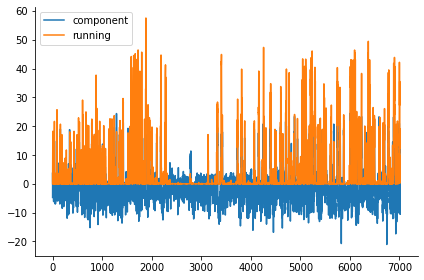

In [176]:
plt.plot(components[:,0], label='component')
plt.plot(running_data, label='running')
plt.legend()
plt.show()

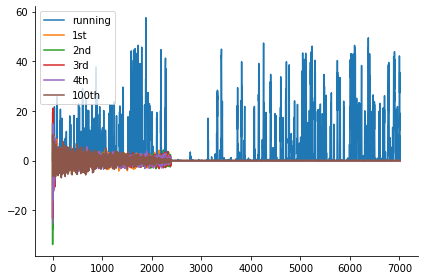

In [131]:
# pearson's after pca, first 100 components
plt.plot(running_data, label='running')
plt.plot(components[1,:], label='1st')
plt.plot(components[2,:], label='2nd')
plt.plot(components[3,:], label='3rd')
plt.plot(components[4,:], label='4th')
plt.plot(components[2395,:], label='100th')

plt.legend()
plt.show()